In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import time

/home/luqman/.local/share/virtualenvs/ME-GraphAU-NHAhuV8b/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# bbox has 4 elements, 1st and 2nd elements are top left x,y coordinates 
# 3rd and 4th elements are top bottom x,y coordinates
def show_img(img_path, bbox):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    cv_img = np.array(img)
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    cv2.rectangle(cv_img, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.imshow(cv_img)
    plt.show()

In [5]:
def rescale_box(box, scale):
    w = box[2] - box[0]
    h = box[3] - box[1]
    cx = box[0] + int(w/2)
    cy = box[1] + int(h/2)
    max_len = max(w, h)
    new_w = int(max_len * scale / 2)
    x1 = cx - new_w
    y1 = cy - new_w
    x2 = cx + new_w
    y2 = cy + new_w
    new_box = [x1,y1,x2,y2]
    return new_box

# crop image and resize to 224x224
def crop_img(img_path, coords, out_path):
    image_obj = Image.open(img_path)
    cropped_image = image_obj.crop(coords)
    img = cropped_image.resize((224,224))
    img.save(out_path)

# Test on a single image

In [9]:
img_path = "/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames/SN009/1768.png"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
frame = Image.fromarray(img)
mtcnn = MTCNN(keep_all=True, device='cuda:0')
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

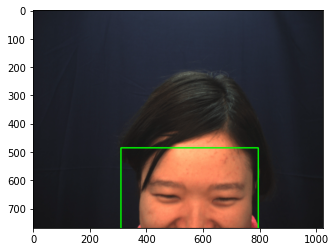

In [17]:
show_img(img_path, boxes[0])

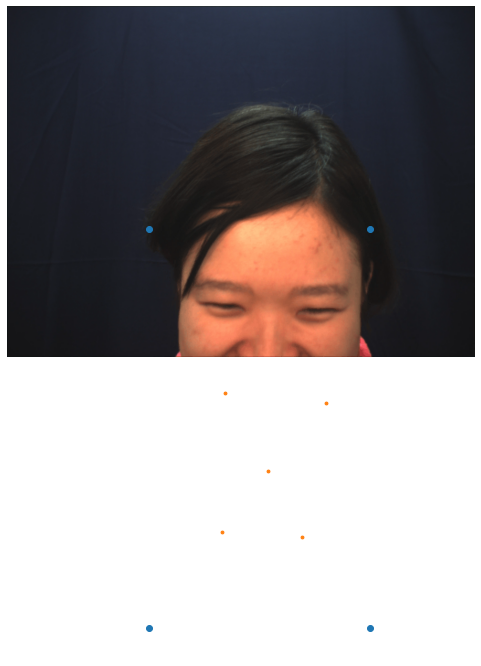

In [11]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

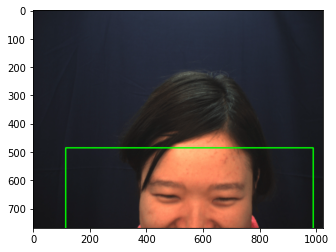

In [16]:
s_box = rescale_box(boxes[0], 1)
show_img(img_path, s_box)

# Run MTCNN

In [10]:
start_time = time.time()
video_names = ['SN009']
input_dir = "/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames"
batch_size = 32
mtcnn = MTCNN(keep_all=True, device='cuda:0')

for v in video_names:
    print(f'Processing {v}')
    frames = []
    boxes = []
    landmarks = []
    probs = []
    img_dir = os.path.join(input_dir, v)
    files_count = len([name for name in os.listdir(img_dir)])
    
    for i in range(files_count):
        filename = str(i+1) + '.png'
        img_path = os.path.join(img_dir, filename)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(img)
        frames.append(frame)

        if (len(frames) == batch_size or (i+1 == files_count)):
            batch_boxes, batch_probs, batch_landmarks = mtcnn.detect(frames, landmarks=True)
            boxes.extend(batch_boxes)
            landmarks.extend(batch_landmarks)
            probs.extend(batch_probs)
            frames = []
    
    output = {'boxes': boxes, 'probs': probs, 'landmarks': landmarks}
    out_filename = v + ".pickle"
    out_path = os.path.join('/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn_output', out_filename)
    outfile = open(out_path, 'wb')
    pickle.dump(output, outfile)
    outfile.close()
    print(f'output is saved on {out_path}')
  
print("--- %s seconds ---" % (time.time() - start_time))

Processing SN009
output is saved on /nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn_output/SN009.pickle
--- 77.30632781982422 seconds ---


# Crop image

In [ ]:
start_time = time.time()
video_names = ['SN009']

box_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn'
input_dir = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames'
output_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img'

for v in video_names:
    f_path = box_path + "/" + v + ".pickle"
    boxes = pickle.load(open(f_path, "rb"))
    img_dir = os.path.join(input_dir, v)
    
    out_dir = os.path.join(output_path, v)
    os.makedirs(out_dir, exist_ok=True)
    
    for i, box in enumerate(boxes):
        in_filename = str(i+1) + ".png"
        img_path = os.path.join(img_dir, in_filename)
        out_filename = str(i) + ".png"
        out_img_path = os.path.join(out_dir, out_filename)
        
        if (box is None):
            command = "cp " + img_path + " " + out_img_path  
            os.system(command)
        else:
            s_box = rescale_box(box[0], 1.3)
            crop_img(img_path, s_box, out_img_path)
            
print("--- %s seconds ---" % (time.time() - start_time))

# Count file in directory

In [16]:
DIR = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img_align'
counter = 0
for d in os.listdir(DIR):
    img_dir = os.path.join(DIR, d)
    l = len([name for name in os.listdir(img_dir)])
    counter += 1
    print(f'{counter} - {d} - {l}')

1 - SN009 - 4818
2 - SN002 - 4845
3 - SN010 - 4844
4 - SN001 - 4845
5 - SN026 - 4845
6 - SN027 - 4845
7 - SN032 - 4845
8 - SN030 - 4845
9 - SN016 - 4845
10 - SN013 - 4845
11 - SN018 - 4845
12 - SN011 - 4845
13 - SN028 - 4845
14 - SN012 - 4845
15 - SN006 - 4845
16 - SN031 - 4845
17 - SN021 - 4845
18 - SN024 - 4845
19 - SN003 - 4845
20 - SN029 - 4845
21 - SN023 - 4845
22 - SN025 - 4845
23 - SN008 - 4845
24 - SN005 - 4845
25 - SN007 - 4845
26 - SN017 - 4845
27 - SN004 - 4845


In [28]:
DIR = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn_output'
counter = 0
for f in os.listdir(DIR):
    file_path = os.path.join(DIR, f)
    output = pickle.load(open(file_path, "rb"))
    counter += 1
    print(f"{counter} - {f} - {len(output['boxes'])}")

1 - SN009.pickle - 4845
2 - SN002.pickle - 4845
3 - SN010.pickle - 4844
4 - SN001.pickle - 4845
5 - SN026.pickle - 4845
6 - SN027.pickle - 4845
7 - SN032.pickle - 4845
8 - SN030.pickle - 4845
9 - SN016.pickle - 4845
10 - SN013.pickle - 4845
11 - SN018.pickle - 4845
12 - SN011.pickle - 4845
13 - SN028.pickle - 4845
14 - SN012.pickle - 4845
15 - SN006.pickle - 4845
16 - SN031.pickle - 4845
17 - SN021.pickle - 4845
18 - SN024.pickle - 4845
19 - SN003.pickle - 4845
20 - SN029.pickle - 4845
21 - SN023.pickle - 4845
22 - SN025.pickle - 4845
23 - SN008.pickle - 4845
24 - SN005.pickle - 4845
25 - SN007.pickle - 4845
26 - SN017.pickle - 4845
27 - SN004.pickle - 4845


In [25]:
path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn_output/SN009.pickle' 
output = pickle.load(open(path, "rb"))
counter = 0

for i, box in enumerate(output['landmarks']):
    if (box is None):
        counter += 1
print(counter)

27


# Delete broken frames

In [6]:
path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img/SN009'

for i in range(1740, 1767):
    filename = str(i) + '.png'
    img_path = os.path.join(path, filename)
    command = "rm " + img_path
    os.system(command)

# Rename frames

In [14]:
path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img_align/SN009'

for i in range(1767, 4845):
    filename = str(i) + '.png'
    img_path = os.path.join(path, filename)
    new_filename = str(i-27) + '.png'
    new_img_path = os.path.join(path, new_filename)
    command = "mv " + img_path + " " + new_img_path
    os.system(command)
print("Done")

Done


# Face alignment

In [2]:
def face_alignment(img: np.ndarray,
                   landmarks: np.ndarray,
                   detector: str = 'mtcnn',
                   left_eye_ratio=(0.38, 0.38),
                   output_width=224,
                   output_height=None):
    # expected MTCNN implementation: https://github.com/timesler/facenet-pytorch

    assert landmarks.shape == (5,2), f'Expected: (5,2), got istead: {landmarks.shape}'
    assert detector in {'mtcnn'}, 'Only MTCNN format is supported right now.'

    if output_height is None:
        output_height = output_width

    landmarks = np.rint(landmarks).astype(np.int32)

    left_eye_x, left_eye_y = landmarks[1,:] # participant's left eye
    right_eye_x, right_eye_y = landmarks[0,:] # participant's right eye

    dY = right_eye_y - left_eye_y
    dX = right_eye_x - left_eye_x

    angle = np.degrees(np.arctan2(dY, dX)) - 180

    center = (int((left_eye_x + right_eye_x) // 2),
                  int((left_eye_y + right_eye_y) // 2))

    right_eye_ratio_x = 1.0 - left_eye_ratio[0]
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    output_dist = (right_eye_ratio_x - left_eye_ratio[0])
    output_dist *= output_width
    scale = output_dist / dist

    M = cv2.getRotationMatrix2D(center, angle, scale)

    t_x = output_width * 0.5
    t_y = output_height * left_eye_ratio[1]
    M[0, 2] += (t_x - center[0])
    M[1, 2] += (t_y - center[1])

    return cv2.warpAffine(img, M, (output_width, output_height), flags=cv2.INTER_CUBIC)

## Test on a single image

In [6]:
img_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames/SN002/1.png'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
frame = Image.fromarray(img)
mtcnn = MTCNN(keep_all=True, device='cuda:0')
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

In [7]:
aligned_img = face_alignment(img, landmarks[0])

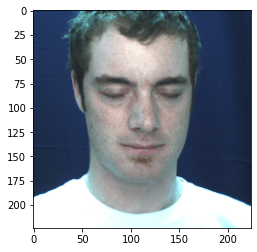

In [8]:
plt.imshow(aligned_img)
plt.show()

In [30]:
image = Image.fromarray(aligned_img)
image.save('/nas/project_data/B1_Behavior/hakim/ME-GraphAU/img/111.png')

## Run face alignment

In [9]:
start_time = time.time()
video_names = ['SN009']
input_dir = "/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames"
output_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img_align'
mtcnn_output_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn_output'

for v in video_names:
    print(f'Processing {v}')
    img_dir = os.path.join(input_dir, v)
    mtcnn_output_file = mtcnn_output_path + "/" + v + ".pickle"
    mtcnn_output = pickle.load(open(mtcnn_output_file, "rb"))
    out_dir = os.path.join(output_path, v)
    os.makedirs(out_dir, exist_ok=True)
    
    for i, landmark in enumerate(mtcnn_output['landmarks']):
        if (mtcnn_output['landmarks'][i] is None):
            continue
        else:
            in_filename = str(i+1) + ".png"
            in_img_path = os.path.join(img_dir, in_filename)
            out_filename = str(i) + ".png"
            out_img_path = os.path.join(out_dir, out_filename)
            landmark = mtcnn_output['landmarks'][i][0]        
            img = cv2.cvtColor(cv2.imread(in_img_path), cv2.COLOR_BGR2RGB)
            aligned_img = face_alignment(img, landmark)
            img = Image.fromarray(aligned_img)
            img.save(out_img_path)
            
print("--- %s seconds ---" % (time.time() - start_time))

Processing SN009
--- 187.19426226615906 seconds ---
